В этом файле попробуем ответить на следующие вопросы: 

1. Что такое рекомендательная система Annoy
2. Что мы знаем, как и где ее выгодно применять
3. Как работает Annoy
4. Как бы мы ее применяли в нашем случае

# Что такое рекомендательная система Annoy

**Annoy** - это библиотека C++ c привязками Python для поиска близкой точки к данной. По скорости и экономии в вопросах памяти эта библиотека идет на равне с остальными.

Можно сказать, что Annoy является такой же библиотекой, как и ее аналоги. Однако, как у всех ее аналогов, здесь есть свои определенные особенности и бонусы для использования конкретно нее. Скорость и расход по памяти считаются развитыми на неплохом уровне.  

# Что мы знаем, как и где ее выгодно применять

В основе Annoy лежит структура - дерево, где каждый элемент связан с "родителем" и "детьми" (не больше 2). Для вычислений используется Евклидова метрика.

Доказано, что наибольшей эффективности можно добиться на выборках с количеством параметров не превосходящих 100. Также считается стабильным и для больших значений.

Присутствует такая особенность: возможность в качестве индексов использовать статические файлы. (Статические файлы - не содержащий вводную YAML. Это изображения, PDF и прочий не рендерящийся контент. То есть это нечто привычные человекочитаемые настоящие файлы.) Файловая структура, основанная на этом, может иметь достаточно большие размеры, но дает доступ к ним только на чтение (read_only), поэтому они не могут испротиться и исказить результат разных процессов. Такой подход разрешает совместное использование данных несколькими процессами, что, конечно же, является плюсом системы. Появляется возможность распараллеливания запросов, что уменьшает и скорость работы.

Хоть Annoy и не считается лидером по оптимальному хранению, она стремится минимизировать объем памяти, так индексы, как правило, случаются маленькими. 

Проводить исследования можно исключительно на фиксированном dataset'е. Причина этого заключается в том, что работа ведется с построенным деревом. При изменении дерева в худшем случае придется пересчитывать все предыдущие результаты.

Стоит сказать про совместимость с языками программирования. Встроена поддержка Python для версий 2.7, 3.6, 3.7.

В Annoy имеется следующий набор функций, адаптированных для языка Python:
1. AnnoyIndex(f, metric) возвращает новый индекс для чтения-записи и сохраняет вектор f измерений. Метрика может быть "angular", "euclidean", "manhattan", "hamming", или "dot". (косинусное расстояние, Евклидово расстояние, Манхэттенское расстояние, расстояние Хэмминга, скалярное произведение)
2. a.add_item(i, v) добавляет элемент i(любое неотрицательное целое число) с вектором v. Обратите внимание, что он выделяет память для max(i)+1 элементов.
3. a.build(n_trees, n_jobs=-1) строит лес из n_trees деревьев. Чем больше деревьев, тем выше точность запросов. После вызова build больше нельзя добавлять элементы. n_jobs указывает количество потоков, используемых для построения деревьев, параметр -1 использует все доступные ядра ЦП.
4. a.save(fn, prefault=False) сохраняет индекс на диск и загружает его (см. следующую функцию). После сохранения больше нельзя добавлять элементы.
5. a.load(fn, prefault=False) загружает (mmaps) индекс с диска. Если для параметра prefault установлено значение True, он предварительно прочитает весь файл в память (используя mmap с MAP_POPULATE). По умолчанию - False.
6. a.unload() выгружает.
7. a.get_nns_by_item(i, n, search_k=-1, include_distances=False) возвращает n ближайшие элементы. Во время запроса он будет проверять до search_k узлов, которые по умолчанию используются, (n_trees * n) если не указаны. search_k дает вам компромисс между лучшей точностью и скоростью во время выполнения. Если вы установите include_distances значение True, он вернет кортеж из двух элементов с двумя списками в нем: второй, содержащий все соответствующие расстояния.
8. a.get_nns_by_vector(v, n, search_k=-1, include_distances=False) то же, но запрос по вектору v.
9. a.get_item_vector(i) возвращает вектор для элемента, i который был добавлен ранее.
10. a.get_distance(i, j) возвращает расстояние между элементами iи j.
11. a.get_n_items() возвращает количество элементов в индексе.
12. a.get_n_trees() возвращает количество деревьев в индексе.
13. a.on_disk_build(fn) подготавливает раздражение для построения индекса в указанном файле вместо ОЗУ (выполнить перед добавлением элементов, нет необходимости сохранять после сборки)
14. a.set_seed(seed) инициализирует генератор случайных чисел с заданным seed. Используется только для построения дерева, то есть необходимо передать его только перед добавлением элементов. Не будет иметь никакого эффекта после вызова a.build (n_trees) или a.load (fn).

Получается, что в рамках нашего проекта, мы вполне можем протестировать данные нашего проекта.

# Как работает Annoy

Использование случайных проекций и построение дерева. В каждом промежуточном узле дерева выбирается случайная гиперплоскость, которая делит пространство на два подпространства. Эта гиперплоскость выбирается путем отбора двух точек из подмножества и взятия гиперплоскости, равноудаленной от них.

Мы проделываем это k раз, чтобы получить лес деревьев. k нужно настроить самостоятельно, определив, отношение точности и производительности.

# Как бы мы ее применяли в нашем случае

В первую очередь нужно подготовить данные. Необходимо привести их к одному виду (формату), исключить повторяющиеся, договориться, как быть с объектами, у которых отсутствует тот или иной параметр...

Для начала, я бы взяла только те объекты, в которых есть вся, требуемая информация: адрес, тип объета, цена, наличие фото, описание (к примеру, метраж объекта). Если система будет грамотно работать на полностью корректных данных, то можно рассмотреть случаи с отсутствием значений в том или ином месте. Если и здесь все хорошо, то увеличить количество параметров. Так наши данные будут основываться на большем количестве факторов, а значит и результат будет точнее.

Когда данные для тестирования готовы, нужно загрузить библиотеку.

In [2]:
pip install --user annoy

     |████████████████████████████████| 646 kB 2.3 MB/s eta 0:00:01
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=579009 sha256=cd82f6356a29fd20cadf7751d6d956a4ce3d243e659095c0219ba00c98b44b63
  Stored in directory: /home/irina/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy
Note: you may need to restart the kernel to use updated packages.


 И подключить библиотеку в самом коде.

Как поступать дальше в целом тоже понятно. Нужно вызвать AnnoyIndex(f, '*some mode*'). Затем добавить объекты с помощью .add_item(i, v). Когда все элементы будут добавлены, построить лес (.build(n)) и сохранить его (.save('*some*')). После можно работать с деревом, получая разные запросы и проверяя корректность работы.

Если вывести лес на графике, то будет нечто подобное:

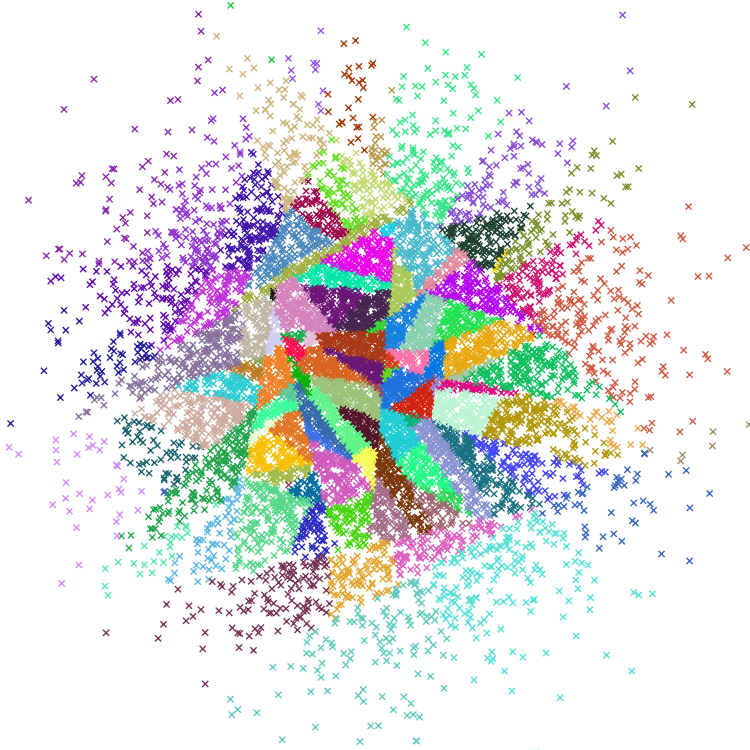

Точки размещенные рядом и имеющие одинаковый окрас и являются похожими объектами в некоторой базе данных, значит их можно рекомендовать пользователям, интересующимся хотя бы одним из них.